# using acs_regional_stats to calculate an area-averaged time series for an ensemble
This notebook shows an example of using acs_regional_stats to calculate an area-averaged time series.

1. starting with a list of files to open, the files are combined to form a dataset with model, time, lat, and lon dimensions.
2. then calculate regional averages. You can do this per model (or by combining all models together)
3. then visualise time series for a selected region for each model (or ensemble average for each region)




In [1]:
# navigate to your directory with "plotting maps" 

In [2]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [3]:
# import needed packages
from acs_area_statistics import acs_regional_stats
import xarray as xr
import geopandas as gpd
import regionmask
import cartopy.crs as ccrs
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# mask
# select masks that define the regions you want to work with
# this shows fractional mask
mask_ncra = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_ncra-regions.nc")['mask']
mask_aust = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_australia.nc")['mask']

mask = xr.concat([mask_ncra, mask_aust], dim="region")
mask = mask.assign_coords({"region":np.arange(0,len(mask["region"]))})

# mask where precipitaiton data is unreliable
directory = "/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i"
agcd = xr.open_dataset(f"{directory}/mask-fraction_agcd_v1-0-2_precip_weight_1960_2022.nc").fraction

In [5]:
# choose a list of files to open
# this list of files will be combined to form a dataset with model, time, lat, and lon dimensions
# we will calculate regional averages and then calculate timeseries for a selected region for each model

gwl="GWL1.2"

var = "p15_3month"
path = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs"

filelist = glob(f"{path}/{var}_AGCD-05i_*_{gwl}_ACS-QME-AGCD-1960-2022.nc")
filelist

['/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_EC-Earth3_ssp370_r1i1p1f1_CSIRO_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_CESM2_ssp370_r11i1p1f1_CSIRO_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_MPI-ESM1-2-HR_ssp370_r1i1p1f1_BOM_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_CNRM-ESM2-1_ssp370_r1i1p1f2_CSIRO_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_CESM2_ssp370_r11i1p1f1_BOM_v1-r1_GW

In [6]:
# open the list of files into one xarray dataset
def _preprocess(ds, var, gwl):
    # mask where precipitation data is unreliable
    return ds.where(agcd>=0.8)

ds = xr.open_mfdataset(filelist, 
                       preprocess= lambda ds: _preprocess(ds, var, gwl),
                       use_cftime=True,
                       combine="nested",
                       concat_dim="model",
                       combine_attrs= "drop_conflicts").load()
ds

<xarray.Dataset> Size: 764MB
Dimensions:     (model: 13, month: 12, lat: 691, lon: 886)
Coordinates:
  * lat         (lat) float64 6kB -44.5 -44.45 -44.4 ... -10.1 -10.05 -10.0
  * lon         (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
    quantile    float64 8B 0.15
  * month       (month) <U3 144B 'NDJ' 'DJF' 'JFM' 'FMA' ... 'ASO' 'SON' 'OND'
Dimensions without coordinates: model
Data variables:
    p15_3month  (model, month, lat, lon) float64 764MB nan nan nan ... nan nan

In [7]:
%%time
# use acs_regiona_stats to calculate the regional mean for each model and month
da_summary =  acs_regional_stats(ds=ds, var=var, mask = mask, dims = ("lat", "lon",), how = ["mean"],)
da_summary

CPU times: user 1.52 s, sys: 850 ms, total: 2.37 s
Wall time: 2.38 s


<xarray.Dataset> Size: 15kB
Dimensions:          (month: 12, region: 10, model: 13)
Coordinates:
    quantile         float64 8B 0.15
  * month            (month) <U3 144B 'NDJ' 'DJF' 'JFM' ... 'ASO' 'SON' 'OND'
    abbrevs          (region) <U8 320B 'WANorth' 'WASouth' ... 'QLDSouth' 'AUS'
    names            (region) <U48 2kB 'Western Australia North' ... 'Australia'
  * region           (region) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: model
Data variables:
    p15_3month_mean  (model, month, region) float64 12kB 136.4 27.32 ... 75.74
Attributes:
    description:  Rainfall percentile threshold calculated for each GWL base ...

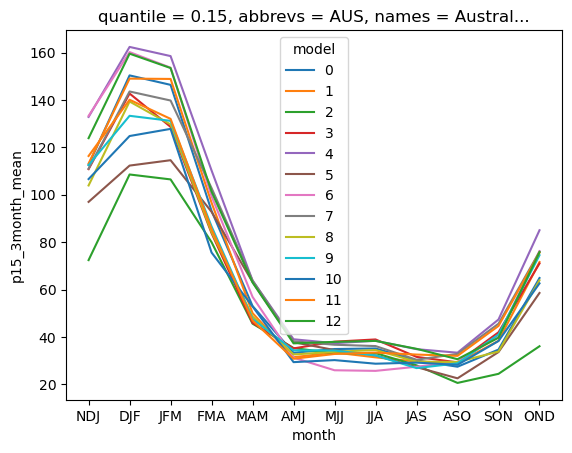

In [8]:
# select the region you like and plot the regional average for each month of each model
da_summary[f"{var}_mean"].sel(region=9).plot.line(x="month");

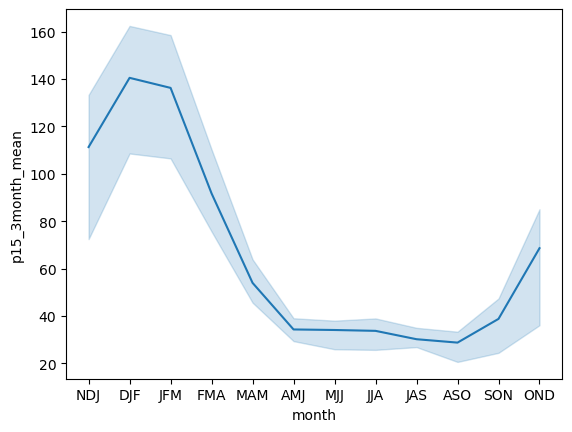

In [9]:
import seaborn as sns

# or, use seaborn to plot the range of values from multiple models
da= da_summary[f"{var}_mean"].sel(region=9).to_dataframe()
sns.lineplot(data=da, x="month", y= f"{var}_mean",  errorbar=("pi", 100) )
plt.savefig("figures/monthly_ensemble.png")

In [10]:
%%time
# Alternatively, use acs_regiona_stats to calculate the regional ensemble mean for each month
da_summary =  acs_regional_stats(ds=ds, var=var, mask = mask, dims = ("lat", "lon", "model"), how = ["mean"],)
da_summary

CPU times: user 2.68 s, sys: 667 ms, total: 3.34 s
Wall time: 3.44 s


<xarray.Dataset> Size: 3kB
Dimensions:          (month: 12, region: 10)
Coordinates:
    quantile         float64 8B 0.15
  * month            (month) <U3 144B 'NDJ' 'DJF' 'JFM' ... 'ASO' 'SON' 'OND'
    abbrevs          (region) <U8 320B 'WANorth' 'WASouth' ... 'QLDSouth' 'AUS'
    names            (region) <U48 2kB 'Western Australia North' ... 'Australia'
  * region           (region) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    p15_3month_mean  (month, region) float64 960B 128.3 31.89 ... 74.03 68.58
Attributes:
    description:  Rainfall percentile threshold calculated for each GWL base ...

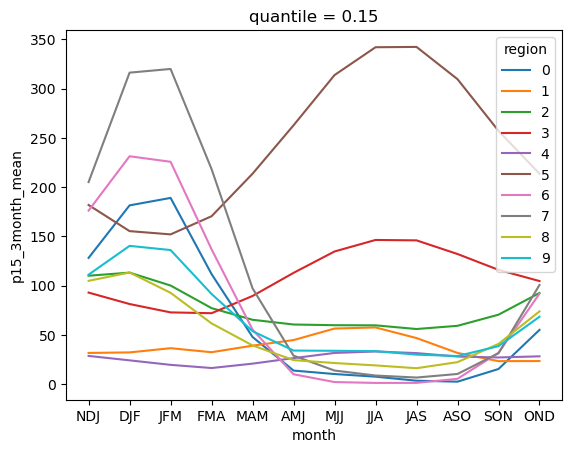

In [11]:
#plot the regional average for each month of the model mean
da_summary[f"{var}_mean"].plot.line(x="month");

In [12]:
# choose a list of files to open
# this list of files will be combined to form a dataset with model, time, lat, and lon dimensions
# we will calculate regional averages and then calculate timeseries for a selected region for each model

gwl="GWL12"

var = "TXx"
path = f"/g/data/ia39/ncra/heat/data/{var}/bias-corrected/individual_models/GWL-timeseries"

filelist = glob(f"{path}/{var}_AGCD-05i_*_v1-r1-ACS-QME-AGCD-1960-2022_{gwl}.nc")
filelist

['/g/data/ia39/ncra/heat/data/TXx/bias-corrected/individual_models/GWL-timeseries/TXx_AGCD-05i_CESM2_ssp370_r11i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1-ACS-QME-AGCD-1960-2022_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/bias-corrected/individual_models/GWL-timeseries/TXx_AGCD-05i_CMCC-ESM2_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1-ACS-QME-AGCD-1960-2022_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/bias-corrected/individual_models/GWL-timeseries/TXx_AGCD-05i_CESM2_ssp370_r11i1p1f1_BOM_BARPA-R_v1-r1-ACS-QME-AGCD-1960-2022_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/bias-corrected/individual_models/GWL-timeseries/TXx_AGCD-05i_EC-Earth3_ssp370_r1i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1-ACS-QME-AGCD-1960-2022_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/bias-corrected/individual_models/GWL-timeseries/TXx_AGCD-05i_MPI-ESM1-2-HR_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1-ACS-QME-AGCD-1960-2022_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/bias-corrected/individual_models/GWL-timeseries/TXx_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1

In [13]:
# open the list of files into one xarray dataset
# The preprocessor to convert the calendar to consistent calendars may be required 
# because different models use different calendars and xarray cannot combine time dimensions with differing calendars 

ds = xr.open_mfdataset(filelist, 
                       preprocess= lambda ds: ds.convert_calendar("standard"),
                       use_cftime=True,
                       combine="nested",
                       concat_dim="model",
                       combine_attrs= "drop_conflicts").load()
ds

<xarray.Dataset> Size: 1GB
Dimensions:  (model: 13, time: 45, lat: 691, lon: 886)
Coordinates:
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * time     (time) datetime64[ns] 360B 2004-01-01 2005-01-01 ... 2048-01-01
Dimensions without coordinates: model
Data variables:
    TXx      (model, time, lat, lon) float32 1GB nan nan nan nan ... nan nan nan
Attributes:
    pathway:                 ssp370
    GWL:                     GWL 1.2 degC
    bias_correction_method:  ACS-QME
    contact:                 Mitchell Black (mitchell.black@bom.gov.au)
    code:                    https://github.com/AusClimateService/hazards-heat

In [14]:
%%time
# Use acs_regiona_stats to calculate the regional mean for each year
da_summary =  acs_regional_stats(ds=ds, var=var, mask = mask, dims = ("lat", "lon",), how = ["mean"],)
da_summary

CPU times: user 5.15 s, sys: 2.83 s, total: 7.98 s
Wall time: 8.41 s


<xarray.Dataset> Size: 49kB
Dimensions:   (time: 45, region: 10, model: 13)
Coordinates:
  * time      (time) datetime64[ns] 360B 2004-01-01 2005-01-01 ... 2048-01-01
    abbrevs   (region) <U8 320B 'WANorth' 'WASouth' 'NSW' ... 'QLDSouth' 'AUS'
    names     (region) <U48 2kB 'Western Australia North' ... 'Australia'
  * region    (region) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: model
Data variables:
    TXx_mean  (model, time, region) float64 47kB nan nan nan nan ... nan nan nan
Attributes:
    long_name:      annual maximum daily maximum temperature
    standard_name:  air_temperature
    units:          degC
    regrid_method:  bilinear
    cell_methods:   time: maximum (interval: 1Y)

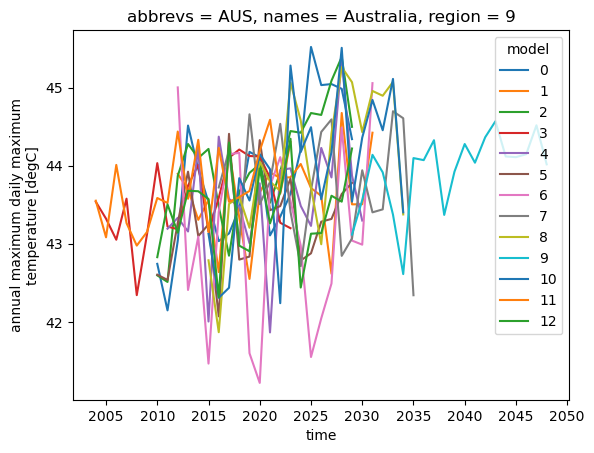

In [15]:
# plot the Australian area average value for each time step for each model
da_summary[f"{var}_mean"].sel(region=9).plot.line(x="time");

<Axes: xlabel='time', ylabel='TXx_mean'>

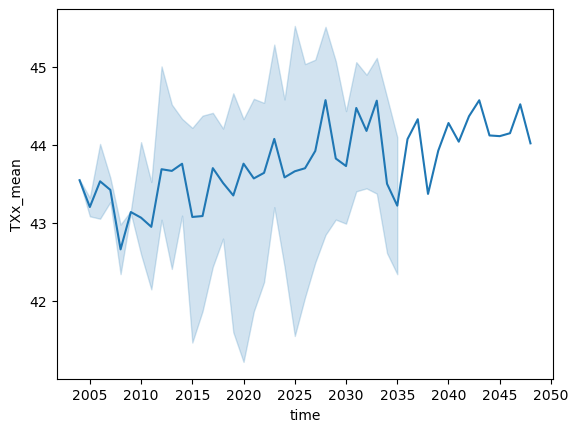

In [16]:
import seaborn as sns

# or, use seaborn to plot the range of values from multiple models
da= da_summary[f"{var}_mean"].sel(region=9).to_dataframe()
sns.lineplot(data=da, x="time", y= f"{var}_mean",  errorbar=("pi", 100) )